# **UNet - Duck, USA : Training and Test**

**Thesis**    : _"Wave-by-wave Nearshore Wave Breaking Identificationusing U-Net"_
              
**Author**    : Francisco Sáez Rosales 

**Email**     : francisco.saez@sansano.usm.cl

**Date**      : 07/06/2021



**Summary**

A machine learning algorithm based on the convolutional neural network U-Net has been trained and validated using as ground truth information a large data set of binary masks obtained from an automated and independent detection algorithm. For  the  identification  of  thebackground data used in training, the discrimination algorithm of Catalán et al. (2011) is used. 

### Folder's path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive'
%cd 'My Drive/UNet_Duck'

Mounted at /content/gdrive
/content/gdrive
/content/gdrive/My Drive/UNet_Duck


### Packages

In [ ]:
# Basic packages
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import tqdm_notebook, tnrange
from itertools import chain

# Function
from create_inputs import *
from conv2d_block import *
from get_unet import *
from plot_prediction import *
from f1 import *

# Packages for neural network
from skimage.io import imread, imshow, concatenate_images
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model, model_from_json
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import array_to_img, img_to_array, load_img

### Inputs

In [ ]:
# Parameters
im_width  = 512
im_height = 512
paths     = {"im_tr":"trainset_duck/image/", 
             "la_tr":"trainset_duck/label/",
             "im_tst": "testset_duck/image/",
             "la_tst":"testset_duck/label/"}

In [ ]:
# List of names all images
ids_xtr   = next(os.walk(paths["im_tr"]))[2]
ids_ytr   = next(os.walk(paths["la_tr"]))[2]
ids_xtst  = next(os.walk(paths["im_tst"]))[2]
ids_ytst  = next(os.walk(paths["la_tst"]))[2]

print("N° of images in train set = ", len(ids_xtr),"\n")
print("N° of labels in train set = ", len(ids_ytr),"\n")
print("N° of images in test set = ", len(ids_xtst),"\n")
print("N° of labels in test set = ", len(ids_ytst),"\n")

N° of images in train set =  700 

N° of labels in train set =  700 

N° of images in test set =  400 

N° of labels in test set =  400 



In [ ]:
# Creating of matrix for train and test set

x_tr, y_tr = create_inputs(ids_xtst,paths["im_tr"],
                           paths["la_tr"], im_height, im_width)   # Train set
x_tst, y_tst = create_inputs(ids_xtst,paths["im_tst"],
                           paths["la_tst"], im_height, im_width)  # Test set

# Save inputs
np.save('Dataset_matrix/x_tr_duck.npy',x_tr)
np.save('Dataset_matrix/y_tr_duck.npy',y_tr)
np.save('Dataset_matrix/x_tst_duck.npy',x_tst)
np.save('Dataset_matrix/y_tst_duck.npy',y_tst)

In [ ]:
# Creating of matrix for test set Marine Radar

# Create matrix
r_tst = np.zeros((len(ids_rtst), im_height, im_width, 1), dtype = np.float32)

for i, index in tqdm_notebook(enumerate(ids_rtst), total = len(ids_rtst)):

  # load image and transform image to array
  x_img   = img_to_array(load_img('testset_duck/image_mr/'+index, grayscale = True))

  # Save images
  r_tst[i] = x_img /255.0

np.save('Dataset_matrix/r_tst_duck.npy',r_tst)

### U-Net - Training

In [ ]:
# Load sets 
x_tr    = np.load('Dataset_matrix/x_tr_duck.npy')
y_tr    = np.load('Dataset_matrix/y_tr_duck.npy')

print('\n Matrix loaded!')
print('==================')

# Split train and validation set
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size = 0.1, random_state=42)

print(" ")
print("Train set shape = ", x_tr.shape, "\n")
print("Validation set shape = ", x_val.shape, "\n")


 Matrix loaded!
 
Train set shape =  (630, 512, 512, 1) 

Validation set shape =  (70, 512, 512, 1) 



In [ ]:
# Input shape
input_img = Input((512, 512, 1), name = 'img')

# Call function and compile
model = get_unet(input_img, 
                 n_filters = 32, 
                 dropout   = 0.2, 
                 batchnorm = True, 
                 seed      = 0)

model.compile(optimizer = Adam(lr=1e-2),
              loss      = 'binary_crossentropy', 
              metrics   = [f1])

# Callbacks to avoid overfitting 
callbacks = [
  EarlyStopping(patience = 10, 
                verbose  = True),
  ReduceLROnPlateau(factor   = 0.1, 
                    patience = 10, 
                    min_lr   = 0.00001, 
                    verbose  = 1),
  ModelCheckpoint('best_model_final.h5', 
                  verbose           = True, 
                  save_best_only    = True, 
                  save_weights_only = True)
  ]

# Training
unet = model.fit(x                = x_tr,
                 y                = y_tr,
                 batch_size       = 2, 
                 epochs           = 50, 
                 verbose          = True, 
                 callbacks        = callbacks,
                 validation_data  = (x_val,y_val))

Epoch 1/50
315/315 [==============================] - 158s 390ms/step - loss: 0.1018 - f1: 0.3036 - val_loss: 0.0171 - val_f1: 0.4975

Epoch 00001: val_loss improved from inf to 0.01709, saving model to best_model_final.h5
Epoch 2/50
315/315 [==============================] - 122s 388ms/step - loss: 0.0145 - f1: 0.6200 - val_loss: 0.0163 - val_f1: 0.6691

Epoch 00002: val_loss improved from 0.01709 to 0.01626, saving model to best_model_final.h5
Epoch 3/50
315/315 [==============================] - 122s 388ms/step - loss: 0.0133 - f1: 0.6635 - val_loss: 0.0116 - val_f1: 0.6721

Epoch 00003: val_loss improved from 0.01626 to 0.01155, saving model to best_model_final.h5
Epoch 4/50
315/315 [==============================] - 122s 389ms/step - loss: 0.0123 - f1: 0.6840 - val_loss: 0.0124 - val_f1: 0.7288

Epoch 00004: val_loss did not improve from 0.01155
Epoch 5/50
315/315 [==============================] - 123s 390ms/step - loss: 0.0110 - f1: 0.7021 - val_loss: 0.0114 - val_f1: 0.6931

Ep

### Save Model

In [ ]:
# Model to JSON
model_json = model.to_json()

with open("model_final.json", "w") as json_file:
    json_file.write(model_json)

# Weights to HDF5
model.save_weights("best_model_final.h5")
print("Saved Model!")
print('=================')

Saved Model!


### Load Model

In [ ]:
# Load JSON and Create model
json_file          =  open('model_final.json', 'r')
loaded_model_json  =  json_file.read()
json_file.close()
model              = model_from_json(loaded_model_json, {"tf":tf})

# Load weight 
model.load_weights("best_model_final.h5")
print("Model Loaded!")
print('=================')

Model Loaded!


### U-Net - Prediction

In [ ]:
# Load Test set Matrix
x_tst   = np.load('Dataset_matrix/x_tst_duck.npy')
y_tst   = np.load('Dataset_matrix/y_tst_duck.npy')

# Load Marine Radar Data 
r_tst   = np.load('Dataset_matrix/r_tst_duck.npy')

print('Test Set Loaded!')
print('=================')

Test Set Loaded!


In [ ]:
# Evaluate on train, validation and test set
eval_tr  = model.evaluate(x_tr, y_tr, verbose = False)
eval_val = model.evaluate(x_val, y_val, verbose = False)
eval_tst = model.evaluate(x_tst, y_tst, verbose = False)

print("Train set - Loss =",np.round(eval_tr[0],6),
      " Accuracy =",np.round(eval_tr[1],3),"\n")
print("Validation set - Loss =",np.round(eval_val[0],3),
      " Accuracy =",np.round(eval_val[1],3),"\n")
print("Test set: Loss =",np.round(eval_tst[0],3),
      " Accuracy =",np.round(eval_tst[1],3))

Train set - Loss = 0.001554  Accuracy = 0.957 

Validation set - Loss = 0.007  Accuracy = 0.895 

Test set: Loss = 0.111  Accuracy = 0.718


In [ ]:
# Prediction on Test set
preds_tst   = model.predict(x_tst, verbose = True)

# Binary mask
preds_tst_t = (preds_tst > 0.5).astype(np.uint8)

print('\n Prediction is ready!')
print('=================')

13/13 [==============================] - 17s 1s/step

 Prediction is ready!


In [ ]:
# Save matrix
sio.savemat('results_test.mat', {'x_tst':x_tst,
                                 'y_tst':y_tst,
                                 'pred':preds_tst})
print('\n Results saved!')
print('=================')


 Results saved!


### Graphs

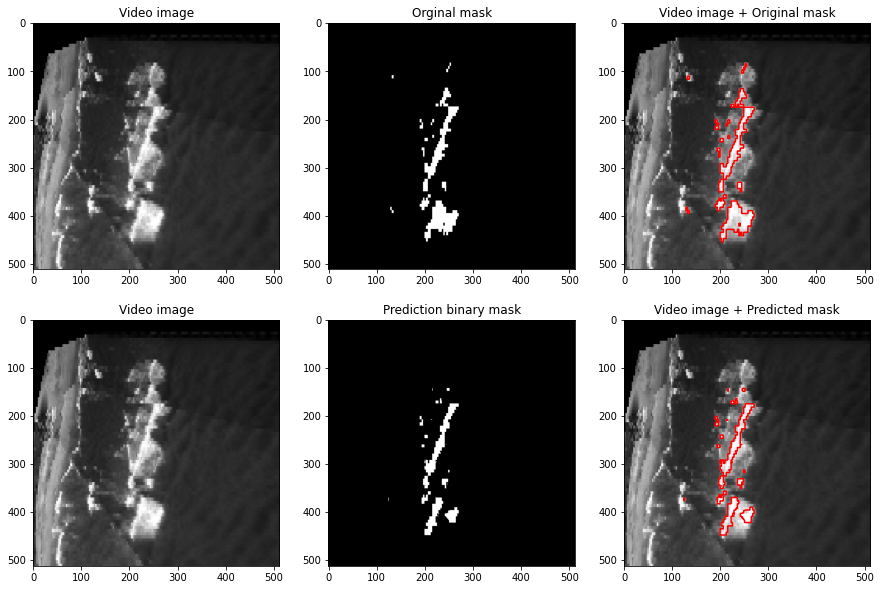

In [ ]:
# Test
plot_prediction(x_tst,
                y_tst, 
                preds_tst_t, 
                index=299)

# Test on images 3, 20, 100, 299, 399

### Learning curve


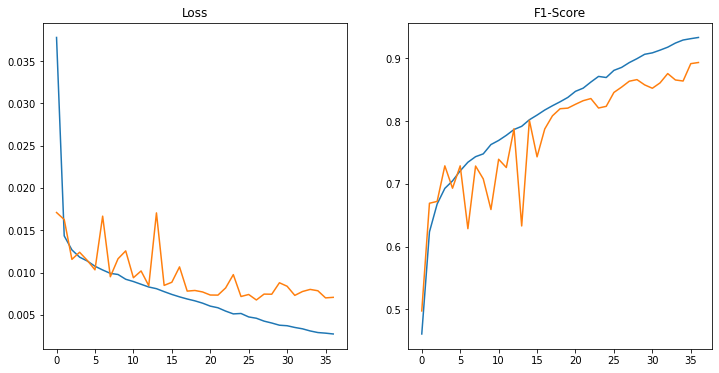

In [ ]:
# Save learning curve
# np.save('Dataset_matrix/history.npy',results_lc)


results_lc = np.load('Dataset_matrix/history.npy')


fig, ax = plt.subplots(1, 2, figsize = (12,6))

ax[0].plot(results_lc["loss"], label = 'Train set')
ax[0].plot(results_lc["val_loss"], label = 'Val set')
ax[0].set_title('Loss')

ax[1].plot(results_lc["f1"], label = 'Train set')
ax[1].plot(results_lc["val_f1"], label = 'Val set')
ax[1].set_title('F1-Score')

plt.show()

### Comparison between original mask and prediction


In [ ]:
# Catalán's mask
true_label = ((y_tst)*100).squeeze()

# Predicted mask
pred_label = ((preds_tst_t)*10).squeeze()

# Sum 
labels = (true_label+pred_label)

# Total
NOpix = np.sum(np.sum(true_label == 100,axis=1),axis=1)
NNpix = np.sum(np.sum(pred_label == 10,axis=1),axis=1)

#  Pixel identification
NM = np.sum(np.sum(labels == 100, axis=1),axis=1)
FA = np.sum(np.sum(labels == 10, axis=1),axis=1)
Y  = np.sum(np.sum(labels == 110,axis=1),axis=1)

np.seterr(divide='ignore', invalid='ignore')

# It's True when both Catalán and Unet pixels are breaking wave
true  = np.divide(Y,NOpix)*100

# It's fail when Unet pixels are not breaking wave and Catalán pixels are breaking wave
fail  = np.divide(NM,NOpix)*100

# It's True when Unet pixels are breaking wave but Catalán pixels are not breaking wave
false = np.divide(FA,NNpix)*100

print('Mean True Pixels =',np.nanmean(true),
      ' Std True Pixels =', np.nanstd(true),'\n')
print('Mean Fail Pixels =',np.nanmean(fail),
      'Std Fail Pixels =', np.nanstd(fail),'\n')
print('Mean False Pixels =',np.nanmean(false),
      ' Std False Pixels =', np.nanstd(false),'\n')

Mean True Pixels = 70.88223726505137  Std True Pixels = 16.046356389527116 

Mean Fail Pixels = 29.117762734948624 Std Fail Pixels = 16.046356389527116 

Mean False Pixels = 23.742401155987807  Std False Pixels = 15.259151492553546 



In [ ]:
# True, False and Fail pixels
mask_true  = (labels == 110)
mask_false = (labels == 10)
mask_fail  = (labels == 100)

# Radar masks
MR_true    = r_tst.squeeze()*mask_true*-80
MR_false   = r_tst.squeeze()*mask_false*-80
MR_fail    = r_tst.squeeze()*mask_fail*-80

# Video masks
V_true     = x_tst.squeeze()*mask_true*255
V_false    = x_tst.squeeze()*mask_false*255
V_fail     = x_tst.squeeze()*mask_fail*255

np.seterr(divide='ignore', invalid='ignore')

# Radar intensity
mean_MR_true = np.nanmean(np.nanmean(np.nanmean(np.where(MR_true!=0, MR_true, np.nan),axis=1),axis=1))
mean_MR_false = np.nanmean(np.nanmean(np.nanmean(np.where(MR_false!=0, MR_false, np.nan),axis=1),axis=1))
mean_MR_fail = np.nanmean(np.nanmean(np.nanmean(np.where(MR_fail!=0, MR_fail, np.nan),axis=1),axis=1))

std_MR_true = np.nanstd(np.nanstd(np.nanstd(np.where(MR_true!=0, MR_true, np.nan),axis=1),axis=1))
std_MR_false = np.nanstd(np.nanstd(np.nanstd(np.where(MR_false!=0, MR_false, np.nan),axis=1),axis=1))
std_MR_fail = np.nanstd(np.nanstd(np.nanstd(np.where(MR_fail!=0, MR_fail, np.nan),axis=1),axis=1))

# Radar intensity
mean_V_true = np.nanmean(np.nanmean(np.nanmean(np.where(V_true!=0, V_true, np.nan),axis=1),axis=1))
mean_V_false = np.nanmean(np.nanmean(np.nanmean(np.where(V_false!=0, V_false, np.nan),axis=1),axis=1))
mean_V_fail = np.nanmean(np.nanmean(np.nanmean(np.where(V_fail!=0, V_fail, np.nan),axis=1),axis=1))

std_V_true = np.nanstd(np.nanstd(np.nanstd(np.where(V_true!=0, V_true, np.nan),axis=1),axis=1))
std_V_false = np.nanstd(np.nanstd(np.nanstd(np.where(V_false!=0, V_false, np.nan),axis=1),axis=1))
std_V_fail = np.nanstd(np.nanstd(np.nanstd(np.where(V_fail!=0, V_fail, np.nan),axis=1),axis=1))

print('\n')
print('Mean MR True ', mean_MR_true, ' Std MR true ', std_MR_true, '\n')
print('Mean MR false ', mean_MR_false, ' Std MR false ', std_MR_false, '\n')
print('Mean MR fail ', mean_MR_fail, ' Std MR fail ', std_MR_fail, '\n')

print('Mean V True ', mean_V_true, ' Std V true ', std_V_true, '\n')
print('Mean V false ', mean_V_false, ' Std V false ', std_V_false, '\n')
print('Mean V fail ', mean_V_fail, ' Std V fail ', std_V_fail, '\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice




Mean MR True  -33.050575  Std MR true  1.7598671 

Mean MR false  -32.664875  Std MR false  1.988268 

Mean MR fail  -32.947086  Std MR fail  2.0165095 

Mean V True  217.83041  Std V true  2.050305 

Mean V false  188.91911  Std V false  3.4820945 

Mean V fail  209.42334  Std V fail  2.6641717 

